# Training model with TTCL layers

This is a pytorch implementation of experiments from [this paper](https://arxiv.org/pdf/1611.03214.pdf)

In [1]:
# !pip install ipywidgets
# !pip install -U tensorly
# !pip install -U tensorly-torch

In [2]:
import tltorch
import torch
from torch import nn
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import CIFAR10
import torchvision.transforms as T
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output

C:\Users\Sasha\anaconda3\lib\site-packages\tltorch\factorized_tensors\core.py:145: UserWarning: Creating a subclass of FactorizedTensor TensorizedTensor with no name.
  warnings.warn(f'Creating a subclass of FactorizedTensor {cls.__name__} with no name.')


In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [4]:
def get_cifar10_transform(train=True):
    if train:
        transform = T.Compose([
            T.RandomCrop(32, padding=4),
            T.RandomHorizontalFlip(),
            T.ToTensor(),
            T.Normalize((0.49139968, 0.48215827 ,0.44653124), (0.24703233, 0.24348505, 0.26158768), inplace=True)

        ])

    else:
        transform = T.Compose([
            T.ToTensor(),
            T.Normalize((0.49139968, 0.48215827 ,0.44653124), (0.24703233, 0.24348505, 0.26158768))
        ])

    return transform

In [5]:
batch_size = 32

train_set = CIFAR10('CIFAR10', train=True, download=True,
                    transform=get_cifar10_transform(train=True))
test_set = CIFAR10('CIFAR10', train=False, download=True,
                   transform=get_cifar10_transform(train=False))
train_loader = DataLoader(train_set, batch_size=batch_size, pin_memory=True, num_workers=2, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, pin_memory=True, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
def plot_losses_epoch(loss, accuracy, train_losses, test_losses, train_accuracies, test_accuracies):
    clear_output()
    fig, axs = plt.subplots(2, 2, figsize=(15, 8))
    axs[0][0].plot(range(1, len(train_losses) + 1), train_losses, label='train')
    axs[0][0].plot(range(1, len(test_losses) + 1), test_losses, label='test')
    axs[0][0].set_ylabel('loss')
    axs[0][0].set_xlabel('epoch')
    axs[0][0].legend()

    axs[0][1].plot(range(1, len(train_accuracies) + 1), train_accuracies, label='train')
    axs[0][1].plot(range(1, len(test_accuracies) + 1), test_accuracies, label='test')
    axs[0][1].set_ylabel('accuracy')
    axs[0][1].set_xlabel('epoch')
    axs[0][1].legend()

    axs[1][0].plot(range(1, len(loss) + 1), loss)
    axs[1][0].set_ylabel('loss')
    axs[1][0].set_xlabel('batch')

    axs[1][1].plot(range(1, len(accuracy) + 1), accuracy)
    axs[1][1].set_ylabel('accuracy')
    axs[1][1].set_xlabel('batch')

    for r_ax in axs:
        for ax in r_ax:
            ax.grid()

    plt.show()

In [7]:
def save_checkpoint(epoch, model, optimizer, train_loss, test_loss, test_accuracy, train_accuracy, path):
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'test_loss' : test_loss,
            'test_accuracy' : test_accuracy,
            'train_accuracy' : train_accuracy
            }, path)

In [8]:
def train_one_epoch(model, train_dataloader, criterion, optimizer, device="cuda:3", desc='Training...', train_losses=[], test_losses=[], train_accuracies=[], test_accuracies=[]):
    model.to(device)
    model.train()

    losses = []
    accuracies = []
    predicted_classes = torch.Tensor()
    true_classes = torch.Tensor()

    batch_num = 0

    for images, labels in tqdm(train_dataloader, desc=desc):
        optimizer.zero_grad()
        images = images.to(device)
        labels = labels.to(device)
        
        logits = model(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        
        losses += [loss.item() * images.shape[0]]
        predicted_classes = torch.cat((predicted_classes, (logits.argmax(dim=-1)).to('cpu')))
        true_classes = torch.cat((true_classes, labels.to('cpu')))
        accuracies += [(logits.argmax(dim=-1).to('cpu') == labels.to('cpu')).double().mean().item()]
        
        if batch_num % 1 == 0:
            plot_losses_epoch(losses, accuracies, train_losses, test_losses, train_accuracies, test_accuracies)
        batch_num += 1
        print(losses[-1])
        
    return losses, predicted_classes.tolist(), true_classes.tolist()


def predict(model, val_dataloader, criterion, device="cuda:3", desc='Evaluating...'):
    model.to(device)
    model.eval()

    val_losses = []
    predicted_classes = torch.Tensor()
    true_classes = torch.Tensor()

    for images, labels in tqdm(val_dataloader, desc=desc):

        images = images.to(device)
        labels = labels.to(device)
        
        with torch.no_grad():
            logits = model(images)
            loss = criterion(logits, labels)
        
        val_losses += [loss.item() * images.shape[0]]
        predicted_classes = torch.cat((predicted_classes, (logits.argmax(dim=-1)).to('cpu')))
        true_classes = torch.cat((true_classes, labels.to('cpu')))

    return val_losses, predicted_classes.tolist(), true_classes.tolist()

In [9]:
def train(train_losses=[], test_losses=[], train_accuracies=[], test_accuracies=[]):
    train_losses = train_losses
    test_losses = test_losses
    train_accuracies = train_accuracies
    test_accuracies = test_accuracies

    for epoch in range(start_epoch + 1, n_epochs + 1):
        train_losses_epoch, train_predicted_classes, train_true_classes = train_one_epoch(model, train_loader, criterion, optimizer, device, f'Training {epoch}/{n_epochs}', train_losses, test_losses, train_accuracies, test_accuracies)
        train_losses += [sum(train_losses_epoch) / len(train_losses_epoch)]
        train_accuracies += [(torch.Tensor(train_predicted_classes) == torch.Tensor(train_true_classes)).type(torch.DoubleTensor).mean().item()]
        
        scheduler.step(epoch)

        test_losses_epoch, test_predicted_classes, test_true_classes = predict(model, test_loader, criterion, device, f'Evaluating... {epoch}/{n_epochs}')
        test_losses += [sum(test_losses_epoch) / len(test_losses_epoch)]
        test_accuracies += [(torch.Tensor(test_predicted_classes) == torch.Tensor(test_true_classes)).type(torch.DoubleTensor).mean().item()]

        if epoch % save_epoch == 0 and epoch > 0:
            save_checkpoint(epoch=epoch, model=model, optimizer=optimizer, train_loss=train_losses, \
                test_loss=test_losses, test_accuracy=test_accuracies, train_accuracy=train_accuracies, \
                path= save_path + f'-epoch{epoch}.pt')
    return train_losses, test_losses, train_accuracies, test_accuracies

In [10]:
import sys
sys.path.insert(0,'../models')
from TTCL import TTCL

In [11]:
inp_ch, inp_h, inp_w = (3, 32, 32)

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
                nn.Conv2d(inp_ch, 64, (3, 3), padding='same'),
                nn.BatchNorm2d(64),
                nn.ReLU()
        )
        self.tcl1 = nn.Sequential(
                TTCL((4, 4, 4), (4, 4, 4), (3, 3), rank=(20, 20, 20, 1), padding='same', p=1),
                nn.BatchNorm2d(64),
                nn.ReLU(),
                nn.MaxPool2d(3, stride=2)
        )
        self.tcl2 = nn.Sequential(
                TTCL((4, 4, 4), (4, 8, 4), (3, 3), rank=(27, 22, 22, 1), padding='same', p=1),
                nn.BatchNorm2d(128),
                nn.ReLU()
        )
        self.tcl3 = nn.Sequential(
                TTCL((4, 8, 4), (4, 8, 4), (3, 3), rank=(23, 23, 23, 1), padding='same', p=1),
                nn.BatchNorm2d(128),
                nn.ReLU(),
                nn.MaxPool2d(3, stride=2)
        )
        self.tcl4 = nn.Sequential(
                TTCL((4, 8, 4), (4, 8, 4), (3, 3), rank=(23, 23, 23, 1), padding='same', p=1),
                nn.BatchNorm2d(128),
                nn.ReLU()
        )
        self.tcl5 = nn.Sequential(
                TTCL((4, 8, 4), (4, 8, 4), (3, 3), rank=(23, 23, 23, 1), padding='same', p=1),
                nn.BatchNorm2d(128),
                nn.ReLU(),
                nn.AvgPool2d(4, stride=4)
        )
        self.linear = nn.Linear(128, 10)
    def forward(self, x):
        x = self.conv(x)
        x = self.tcl1(x)
        x = self.tcl2(x)
        x = self.tcl3(x)
        x = self.tcl4(x)
        x = self.tcl5(x)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        return x

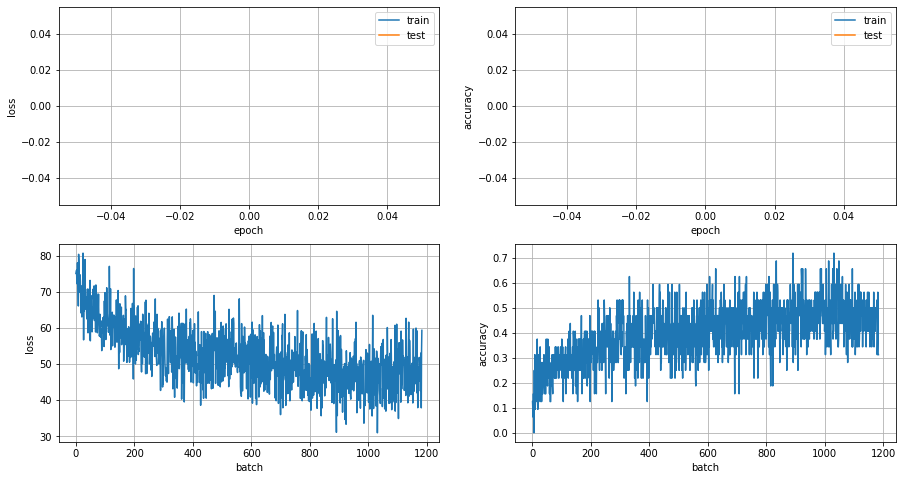

59.367340087890625



RuntimeError: [enforce fail at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\c10\core\impl\alloc_cpu.cpp:81] data. DefaultCPUAllocator: not enough memory: you tried to allocate 19267584 bytes.

In [12]:
from torch.optim.lr_scheduler import MultiStepLR
start_epoch = 60
RESUME = False
criterion = nn.CrossEntropyLoss()

n_epochs = 100
save_epoch = 50

inp_ch, inp_h, inp_w = (3, 32, 32)

stats = []
model = Model()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1, momentum=0.9)
train_losses, test_losses, train_acc, test_acc = [], [], [], []
start_epoch = 0

import os
dir_path = f'trained_models/'
os.makedirs(dir_path, exist_ok=True)
save_path = dir_path + f'TTCL-conv'

milestones = [30, 60, 90]
scheduler = MultiStepLR(optimizer, milestones=milestones, gamma=0.1)
cur_train_losses, cur_test_losses, cur_train_accuracies, cur_test_accuracies = train(train_losses, test_losses, train_acc, test_acc)
stats.append({'train_losses' : cur_train_losses,
            'test_losses' : cur_test_losses,
            'train_accuracies' : cur_train_accuracies,
            'test_accuracies' : cur_test_accuracies})
RESUME = False